# Centroids version

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import local_binary_pattern
from skimage.feature import hog


In [2]:
# Metaparameters
colorspace= 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient= 12
pix_per_cell= 4
cell_per_block= 1 #2
hog_channel= 'ALL' # Can be 0, 1, 2, or "ALL"


In [3]:
# Python implementation of HOG based on OpenCV
def histoGrad(img, binCount=12, cellSize=4):
    gx,gy= cv2.Sobel(img,cv2.CV_32F,1,0), cv2.Sobel(img,cv2.CV_32F,0,1)
    magnitude,angle= cv2.cartToPolar(gx,gy)
    bins= np.int32(binCount*angle*(1-1e-7)/(2*np.pi)) #scale back angle to avoid overbinning
    binCells,magCells= [],[]
    cx= cy= cellSize
    for i in range(0,int(img.shape[0]/cy)):
        for j in range(0,int(img.shape[1]/cx)):
            binCells.append(bins[i*cy:i*cy+cy, j*cx:j*cx+cx])
            magCells.append(magnitude[i*cy:i*cy+cy, j*cx:j*cx+cx])
    hist= np.hstack([np.bincount(i.ravel(), j.ravel(), binCount) for i,j in zip(binCells, magCells)])
    return np.sqrt(hist/(hist.sum()+1e-8)) # apply Hellinger kernel (L1-normalize and sqrt)

In [4]:
# Define a function to return HOG features and visualization

# SciKit version:
def XXget_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# OpenCV version:
def XXXget_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    hog= cv2.HOGDescriptor("hog.xml") #args ignored, xml file must be edited
    features= hog.compute( img.astype(np.uint8) )
    return features.reshape((432,))

# Self version:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    features= histoGrad( img, orient, pix_per_cell )
    return features.reshape((192,))

# Define a function to return LBP features
def get_lpb_features(img):
    lbp= np.ravel(local_binary_pattern(img, 16, 2, method='uniform'))
    #print(lbp.shape)
    return lbp



In [5]:
#from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cells=True, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features= []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image= mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        
        if cells: # Already sized at 16x16 cells
            if hog_channel == 'ALL':
                hog_features= []
                for channel in range(feature_image.shape[2]):
                    #hog_features.append(get_hog_features(feature_image[:,:,channel], 
                    #                    orient, pix_per_cell, cell_per_block, 
                    #                    vis=False, feature_vec=True))
                    
                    # Attempt to train on gradient AND smaller color patch
                    hog_features.append(np.concatenate((get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True), np.ravel(cv2.resize(feature_image[:,:,channel], (4,4), interpolation=3) ) ))) #CV_INTER_AREA
                    #hog_features.append(np.concatenate((get_hog_features(feature_image[:,:,channel], 
                    #                    orient, pix_per_cell, cell_per_block, 
                    #                    vis=False, feature_vec=True), get_lpb_features(feature_image[:,:,channel]))))
                    #hog_features.append(feature_image[:,:,channel])
                hog_features= np.ravel(hog_features)        
            else:
                hog_features= get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(hog_features)
            
        else:
            #first, slice the 64x64 image into quads by column
            quad= []
            quad.append(feature_image[:, 0:16,:])
            quad.append(feature_image[:,16:32,:])
            quad.append(feature_image[:,32:48,:])
            quad.append(feature_image[:,48:64,:])
            for i in range(4):
                #next, slice the quad into cells(16x16) by row
                square= []
                square.append(quad[i][ 0:16,:,:])
                square.append(quad[i][16:32,:,:])
                square.append(quad[i][32:48,:,:])
                square.append(quad[i][48:64,:,:])
                for j in range(4):
                    feature_image= square[j]
                    # Call get_hog_features() with vis=False, feature_vec=True
                    if hog_channel == 'ALL':
                        hog_features = []
                        for channel in range(feature_image.shape[2]):
                            #hog_features.append(get_hog_features(feature_image[:,:,channel], 
                            #                    orient, pix_per_cell, cell_per_block, 
                            #                    vis=False, feature_vec=True))
                            
                            # Attempt to train on gradient AND smaller color patch
                            hog_features.append(np.concatenate((get_hog_features(feature_image[:,:,channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=False, feature_vec=True), np.ravel(cv2.resize(feature_image[:,:,channel], (4,4), interpolation=3) ) ))) #CV_INTER_AREA
                            #hog_features.append(np.concatenate((get_hog_features(feature_image[:,:,channel], 
                            #                    orient, pix_per_cell, cell_per_block, 
                            #                    vis=False, feature_vec=True), get_lpb_features(feature_image[:,:,channel]))))
                            #hog_features.append(feature_image[:,:,channel])
                        hog_features = np.ravel(hog_features)        
                    else:
                        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                    # Append the new feature vector to the features list
                    features.append(hog_features)
            del quad, square
    # Return list of feature vectors
    return features

# load filenames of images containing vehicles
cars = []
vimages = glob.glob('training/vehicles/JWD_vcells/*.png')
for image in vimages:
    cars.append(image)

# load filenames of images containing non-vehicles
nimages = glob.glob('training/non-vehicles/Extras/*.png')
notcars = []
for image in nimages:
    notcars.append(image)

del vimages, nimages
# Reduce the sample size because HOG features are slow to compute
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
print('Step complete.')

Step complete.


In [6]:
# Load data from files into training arrays
t=time.time()
print('Extracting cells of cars...')
car_features= extract_features(cars, cells=True, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print('Extracting notcars images...')
notcar_features= extract_features(notcars, cells=False, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# load additional cells containing non-vehicles
nimages= glob.glob('training/non-vehicles/JWD_ncells/*.png')
notcars= []
for image in nimages:
    notcars.append(image)
print('Extracting cells of notcars...')
notcarcell_features= extract_features(notcars, cells=True, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
del nimages

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

print(np.array(car_features).shape, np.array(notcar_features).shape, np.array(notcarcell_features).shape)
# Create an array stack of feature vectors
X= np.vstack((car_features, notcar_features, notcarcell_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler= StandardScaler().fit(X)
# Apply the scaler to X
scaled_X= X_scaler.transform(X)
print('Updating scaler.dat')
joblib.dump(X_scaler, 'scalar.dat')  # save for later use by classifier

# Define the labels vector
y= np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)), np.zeros(len(notcarcell_features))))

# Split up data into randomized training and test sets
rand_state= np.random.randint(0, 100)
X_train, X_test, y_train, y_test= train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

del scaled_X, y, cars, notcars
del car_features, notcar_features, notcarcell_features
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Extracting cells of cars...
Extracting notcars images...
Extracting cells of notcars...
29.4 Seconds to extract HOG features...
(2405, 624) (15488, 624) (3495, 624)
Updating scaler.dat
Using: 12 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 624


In [152]:
# Define a linear SVC (CPU-based)
#svc = LinearSVC()
from sklearn import svm
svc = svm.SVC(kernel='poly', gamma=2)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('   The SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

590.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9549
   The SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
0.1115 Seconds to predict 10 labels with SVC


In [7]:
# Define a non-linear binary classification model using Keras on TensorFlow

#####################################################################################################################
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

#model= Sequential([
#    Dense(1296, input_dim=len(X_train[0]), init='normal', activation='relu'),
#    Dropout(.5),
#    Dense(1, init='normal', activation='sigmoid')
#])

#model= Sequential([
#    Dropout(.5, input_shape=(len(X_train[0]),) ),
#    Dense(512, init='normal', activation='relu'),
#    Dropout(.5),
#    Dense(1, init='normal', activation='sigmoid')
#])
model= Sequential([
    Dropout(.5, input_shape=(len(X_train[0]),) ),
    Dense(255, init='normal', activation='relu'),
    Dropout(.5),
    Dense(127, init='normal', activation='relu'),
    Dropout(.5),
    Dense(1, init='normal', activation='sigmoid')
])


# binary classification
model.compile(optimizer='adam',  #rmsprop
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dropout_1 (Dropout)              (None, 624)           0           dropout_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 255)           159375      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 255)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 127)           32512       dropout_2[0][0]                  
___________________________________________________________________________________________

In [8]:
# Check the training time for the GPU-based model
t=time.time()
model.fit(X_train, y_train, nb_epoch=35, batch_size=32, shuffle=True, verbose=2)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Net...')
# Check the score of the Net
print('Test Accuracy of Net = ', round(model.evaluate(X_test, y_test, batch_size=16)[1], 4))


Epoch 1/35
7s - loss: 0.2705 - acc: 0.9021
Epoch 2/35
5s - loss: 0.1836 - acc: 0.9288
Epoch 3/35
4s - loss: 0.1524 - acc: 0.9426
Epoch 4/35
4s - loss: 0.1293 - acc: 0.9534
Epoch 5/35
4s - loss: 0.1214 - acc: 0.9566
Epoch 6/35
4s - loss: 0.1069 - acc: 0.9618
Epoch 7/35
5s - loss: 0.0972 - acc: 0.9666
Epoch 8/35
5s - loss: 0.0906 - acc: 0.9670
Epoch 9/35
5s - loss: 0.0833 - acc: 0.9709
Epoch 10/35
4s - loss: 0.0800 - acc: 0.9723
Epoch 11/35
5s - loss: 0.0835 - acc: 0.9702
Epoch 12/35
4s - loss: 0.0758 - acc: 0.9735
Epoch 13/35
5s - loss: 0.0754 - acc: 0.9727
Epoch 14/35
5s - loss: 0.0702 - acc: 0.9756
Epoch 15/35
5s - loss: 0.0703 - acc: 0.9754
Epoch 16/35
5s - loss: 0.0658 - acc: 0.9758
Epoch 17/35
5s - loss: 0.0662 - acc: 0.9762
Epoch 18/35
4s - loss: 0.0655 - acc: 0.9767
Epoch 19/35
4s - loss: 0.0633 - acc: 0.9793
Epoch 20/35
5s - loss: 0.0641 - acc: 0.9782
Epoch 21/35
4s - loss: 0.0594 - acc: 0.9809
Epoch 22/35
5s - loss: 0.0572 - acc: 0.9789
Epoch 23/35
4s - loss: 0.0570 - acc: 0.97

In [12]:
# Run additional training epochs (if necessary)
t=time.time()
model.fit(X_train, y_train, nb_epoch=7, batch_size=32, shuffle=True, verbose=2)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Net...')
print('Test Accuracy of Net = ', round(model.evaluate(X_test, y_test, batch_size=16, verbose=1)[1], 4))


Epoch 1/7
5s - loss: 0.0457 - acc: 0.9842
Epoch 2/7
4s - loss: 0.0422 - acc: 0.9868
Epoch 3/7
4s - loss: 0.0415 - acc: 0.9860
Epoch 4/7
4s - loss: 0.0458 - acc: 0.9850
Epoch 5/7
4s - loss: 0.0449 - acc: 0.9857
Epoch 6/7
4s - loss: 0.0432 - acc: 0.9855
Epoch 7/7
4s - loss: 0.0405 - acc: 0.9865
34.08 Seconds to train Net...
2122/2122 [==============================] - 0s     

In [9]:
# Finish training with test data
t=time.time()
model.fit(X_test, y_test, nb_epoch=21, batch_size=32, shuffle=True, verbose=2)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Net...')
# Check the score of the Net
print('Test Accuracy of Net = ', round(model.evaluate(X_train[:1000], y_train[:1000], batch_size=16, verbose=1)[1], 4))


Epoch 1/21
0s - loss: 0.0852 - acc: 0.9762
Epoch 2/21
0s - loss: 0.0778 - acc: 0.9719
Epoch 3/21
0s - loss: 0.0718 - acc: 0.9762
Epoch 4/21
0s - loss: 0.0532 - acc: 0.9818
Epoch 5/21
0s - loss: 0.0650 - acc: 0.9804
Epoch 6/21
0s - loss: 0.0714 - acc: 0.9771
Epoch 7/21
0s - loss: 0.0448 - acc: 0.9855
Epoch 8/21
0s - loss: 0.0584 - acc: 0.9804
Epoch 9/21
0s - loss: 0.0640 - acc: 0.9794
Epoch 10/21
0s - loss: 0.0475 - acc: 0.9822
Epoch 11/21
0s - loss: 0.0413 - acc: 0.9883
Epoch 12/21
0s - loss: 0.0402 - acc: 0.9836
Epoch 13/21
0s - loss: 0.0452 - acc: 0.9832
Epoch 14/21
0s - loss: 0.0400 - acc: 0.9874
Epoch 15/21
0s - loss: 0.0282 - acc: 0.9878
Epoch 16/21
0s - loss: 0.0334 - acc: 0.9874
Epoch 17/21
0s - loss: 0.0454 - acc: 0.9874
Epoch 18/21
0s - loss: 0.0344 - acc: 0.9897
Epoch 19/21
0s - loss: 0.0337 - acc: 0.9902
Epoch 20/21
0s - loss: 0.0358 - acc: 0.9892
Epoch 21/21
0s - loss: 0.0369 - acc: 0.9892
12.03 Seconds to train Net...
 976/1000 [============================>.] - ETA: 0s

In [10]:
# Save the model

import os
import json
import errno

def deleteFile(file):
    try:
        os.remove(file)
    except OSError as error:
        if error.errno != errno.ENOENT:
            raise


# Save the model and weights
deleteFile('model.json')
deleteFile('model.h5')
jsonString = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(jsonString, outfile)
model.save_weights('model.h5')


In [11]:
del X_train, X_test, y_train, y_test

In [50]:

del model

In [5]:
model= None
import json
from keras.models import model_from_json
with open('model.json', 'r') as jfile:
    model = model_from_json(json.loads(jfile.read()))
model.compile("adam", "binary_crossentropy")
#weights_file = args.model.replace('json', 'h5')
model.load_weights('model.h5')
model.summary()
from sklearn.externals import joblib
X_scaler= joblib.load('scalar.dat')


Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dropout_1 (Dropout)              (None, 624)           0           dropout_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 255)           159375      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 255)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 127)           32512       dropout_2[0][0]                  
___________________________________________________________________________________________

In [12]:
def getFeaturesFromColorPatch(patch, orient=12, pix_per_cell=4, cell_per_block=1):
    global firstTime
    hog_features = []
    feature_patch= cv2.cvtColor(patch, cv2.COLOR_RGB2YCrCb)
    for channel in range(feature_patch.shape[2]):
        #hog_features.append(get_hog_features(feature_patch[:,:,channel], 
        #                    orient, pix_per_cell, cell_per_block, 
        #                    vis=False, feature_vec=True))
        
        # Compute gradient AND small color patch (note: color scaling)
        hog_features.append(np.concatenate((get_hog_features(feature_patch[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True), np.ravel(cv2.resize(feature_patch[:,:,channel], (4,4), interpolation=3) )/255. ))) #CV_INTER_AREA
        #hog_features.append(np.concatenate((get_hog_features(feature_patch[:,:,channel], 
        #                    orient, pix_per_cell, cell_per_block, 
        #                    vis=False, feature_vec=True), get_lpb_features(feature_patch[:,:,channel]))))
        #hog_features.append(np.zeros(432))   # <--- short out
    return np.ravel(hog_features)

def scalePatch(patch):
    global X_scaler # use previously defined scaler
    X= patch.astype(np.float64).reshape((1, -1))                       
    # Apply the scaler to X
    return np.array(X_scaler.transform(X))


In [14]:
# Batch version
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg

def resizePatch(img):
    if len(img[0]) != 16:
        if len(img[0])>16:
            patch= cv2.resize(img, (16,16), interpolation=3) #CV_INTER_AREA
        else:
            patch= cv2.resize(img, (16,16), interpolation=2) #CV_INTER_CUBIC
    else:
        patch= img
    return patch

def preparePatch(p):
    patch= resizePatch(p)
    fpatch= getFeaturesFromColorPatch(patch)
    spatch= scalePatch(fpatch)
    return spatch

diagScreen= None
imgGlobal= None
patchBatch= []
predictionBatch= []

def addPatch(p,x,y,s):
    global patchBatch
    patchBatch.append([p,x,y,s])

def processStripB(x,y,s):
    global frameCount, imgGlobal
    for i in range(4):
        addPatch(imgGlobal[y:y+s, x:x+s, :],x,y,s)
        y= y+s

def locateCentroid(twoDimArray, prevCenterTuple):
    mask= np.zeros_like(lst)
    cv2.ellipse(mask, (prevCenterTuple, (7,4),0), 1,-1)
    masked= cv2.bitwise_and(mask, twoDimArray)
    m= cv2.moments(np.array(masked),True)
    return m['m10']/m['m00'], m['m01']/m['m00']

prevCentroid= (18,2)
pThresh= 0.9
def processBatch(): # send the batch to the GPU for predictions
    global frameCount, patchBatch, predictionBatch, diagScreen, prevCentroid, pThresh
    prepBatch= []
    for i in range( len(patchBatch) ):
        prepBatch.append( preparePatch(patchBatch[i][0]) )
    predictionBatch= model.predict( np.array(prepBatch).reshape((60,-1)) )
    for i in range( len(patchBatch) ):
        x= patchBatch[i][1]
        y= patchBatch[i][2]
        s= patchBatch[i][3]
        if predictionBatch[i]>pThresh:   #0.9
            diagScreen[y:y+s, x:x+s, 1]= 255  #  Green
        else:
            if i>4 and i<56 and predictionBatch[i+4]>pThresh and predictionBatch[i-4]>pThresh:
                diagScreen[y:y+s, x:x+s, 0]= 200 # red
                diagScreen[y:y+s, x:x+s, 1]= 100 # green
#            diagScreen[y:y+s-1, x:x+s-1, 0]= 63   #157  Red

            # Output cell if this negative is surrounded by positives
            #if i>4 and i<56 and predictionBatch[i+4]>0.5 and predictionBatch[i-4]>0.5:
            #mpimg.imsave('output_images/cells/'+str(frameCount)+'-'+str(x)+'-'+str(y)+'.PNG',resizePatch(patchBatch[i][0]))

def redrawBatch(): # redraw the last batch
    global patchBatch, predictionBatch, diagScreen, pThresh
    for i in range( len(patchBatch) ):
        x= patchBatch[i][1]
        y= patchBatch[i][2]
        s= patchBatch[i][3]
        if predictionBatch[i]>pThresh:   #0.9
            diagScreen[y:y+s, x:x+s, 1]= 255  #200  Green
        else:
            if i>4 and i<56 and predictionBatch[i+4]>pThresh and predictionBatch[i-4]>pThresh:
                diagScreen[y:y+s, x:x+s, 0]= 200 # red
                diagScreen[y:y+s, x:x+s, 1]= 100 # green
#            diagScreen[y:y+s-1, x:x+s-1, 0]= 63   #157  Red
            #mpimg.imsave('output_images/cells/'+str(frameCount)+'-'+str(x)+'-'+str(y)+'.PNG',resizePatch(patchBatch[i][0]))
    patchBatch= []
    predictionBatch= []

def process(img):
    global diagScreen, frameCount, imgGlobal
    diagScreen= np.zeros_like(img).astype(np.uint8)  #*127
    imgGlobal= img
    #for i in range(15):
    #if frameCount>=182 and frameCount<=189:
    #if frameCount==122:                  # <-------------------------------------- FRAME
    #if frameCount>=882 and frameCount<=892:
    if frameCount%2==0:
        processStripB( 766,411,14)    # add patches to batch
        processStripB( 780,410,16)
        processStripB( 796,410,18)
        processStripB( 814,409,20)
        processStripB( 834,409,23)
        processStripB( 857,408,25)
        processStripB( 882,407,28)
        processStripB( 910,406,31)
        processStripB( 941,406,35)
        processStripB( 976,405,38)
        processStripB(1014,403,43)
        processStripB(1057,402,46)
        processStripB(1103,401,52)
        processStripB(1155,398,59)
        processStripB(1214,397,66)
        processBatch()
    else:
        redrawBatch()

    cv2.putText(img, str(frameCount), (1200,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))
    result= cv2.addWeighted(img, 1, diagScreen, 0.5, 0) # annotate the original
    #result= diagScreen
    frameCount+= 1
    return result

def procVideo(fileName):
    global frameCount
    frameCount= 0
    clip= VideoFileClip(fileName)
    imgName= fileName.split('/')[1]
    project_video_output= 'output_images/'+imgName
    print('Processing video...')
    project_video_clip= clip.fl_image(process)
    t=time.time()
    project_video_clip.write_videofile(project_video_output, audio=False)
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to complete. ', round(frameCount/(t2-t), 2), 'fps' )

procVideo('video/project_video.mp4')

Processing video...
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:47<00:00, 12.48it/s]  0%|▏                                                                                                                          | 2/1261 [00:00<01:28, 14.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

108.71 seconds to complete.  11.6 fps


In [ ]:
import cv2
help(cv2.HOGDescriptor())

In [6]:
hog = cv2.HOGDescriptor()
hog.save("hog.xml")

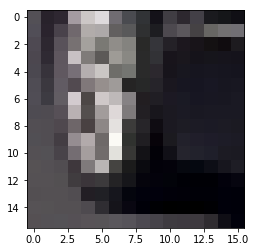

array([[ 0.99998367]], dtype=float32)

In [13]:
img2= mpimg.imread('training/vehicles/JWD_vcells/3.PNG')
plt.imshow(img2)
plt.show()
model.predict( np.array( preparePatch ( img2) ).reshape((1,-1)) )

In [19]:
# Computing the X values for sliding windows
x= np.linspace(0, 14, 15)
y=np.array([766,780,796,814,834,857,882,910,941,976,1014,1057,1103,1155,1214])
coefsX= np.polyfit(x,y,3)
print(coefsX)

[  5.02765209e-02   5.67496229e-01   1.41637399e+01   7.65433333e+02]


In [21]:
# Computing the S values for sliding windows
s=np.array([14,16,18,20,23,25,28,31,35,38,43,46,52,59,66])
coefsS= np.polyfit(x,s,2)
print(coefsS)

[  0.17946025   1.01969942  14.98529412]


[ -5.49450549e-02  -1.87912088e-01   4.10500000e+02]


[ -5.49450549e-02  -1.87912088e-01   4.10500000e+02]


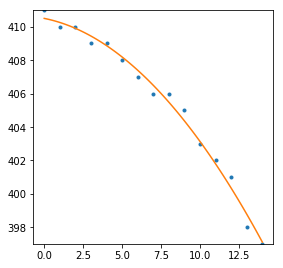

In [24]:
# Computing the Y values for sliding windows
y=np.array([411,410,410,409,409,408,407,406,406,405,403,402,401,398,397])
coefsY= np.polyfit(x,y,2)
print(coefsY)
f= np.poly1d(coefsY)
xp = np.linspace(0, 14, 100)
_=plt.figure( figsize=(4.3,4.3) )
_= plt.plot(x, y, '.', xp, f(xp), '-')
#_=plt.ylim(766,1214)
_=plt.ylim(397,411)
#_=plt.ylim(14,66)
plt.show()

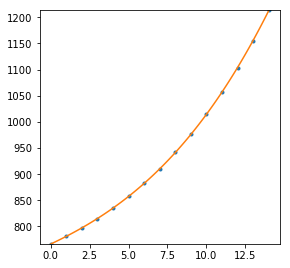

In [20]:
# Computing the X values for sliding windows
x= np.linspace(0, 14, 15)
y=np.array([766,780,796,814,834,857,882,910,941,976,1014,1057,1103,1155,1214])
coefsX= np.polyfit(x,y,3)
print(coefsX)
f= np.poly1d(coefsX)
xp = np.linspace(0, 14, 100)
_=plt.figure( figsize=(4.3,4.3) )
_= plt.plot(x, y, '.', xp, f(xp), '-')
_=plt.ylim(766,1214)
#_=plt.ylim(397,411)
#_=plt.ylim(14,66)
plt.show()

[  0.17946025   1.01969942  14.98529412]


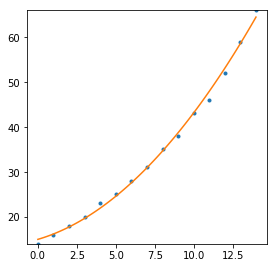

In [25]:
# Computing the S values for sliding windows
s=np.array([14,16,18,20,23,25,28,31,35,38,43,46,52,59,66])
coefsS= np.polyfit(x,s,2)
print(coefsS)
f= np.poly1d(coefsS)
xp = np.linspace(0, 14, 100)
_=plt.figure( figsize=(4.3,4.3) )
_= plt.plot(x, s, '.', xp, f(xp), '-')
#_=plt.ylim(766,1214)
#_=plt.ylim(397,411)
_=plt.ylim(14,66)
plt.show()

In [132]:
#_______________________________________________________________________________
# Circular queuing class made with Numpy

class NQ():
    def __init__(self,qlen,shape,dtype=np.uint8):
        self.data= np.empty(shape=shape,dtype=dtype)
        self.qlen= qlen
    def put(self,a):
        self.data= np.append(self.data,a, axis=0)
        if len(self.data)>self.qlen: self.drop()
    def peek(self):
        return self.data[len(self.data)-1]
    def drop(self):
        self.data= np.delete(self.data, 0, axis=0)
    def getAvg(self):
        newList= np.copy(self.data[0])
        newList[:,1]= np.sum(self.data[:,:,1], axis=0)/float(len(self.data))
        return newList


#_______________________________________________________________________________
# Vehicle tracking class

class Vehicle():
    def __init__(self, color, left,top, width,height):
        self.color= color
        self.left= left
        self.top= top
        self.width= width
        self.height= height
        self.dx= 0  # relative speed (computed over frames)
        self.dy= 0
        self.refQ= NQ(4,(0,1))   #4 frames containing an array of refdata
        self.centroidX= left+width/2
        self.centroidY= top+height/2
        
    def updateCentroid(self):  #based on reference queue
        #zip through the queue and update location of centroid
        for i in range(len(self.refQ)):
            pass #  data= self.refQ.peek()
        lastX= self.centroidX
        lastY= self.centroidY
        self.centroidX= left+width/2
        self.centroidY= top+height/2
        #also update dx,dy
        self.dx= self.centroidX-lastX
        self.dy= self.centroidY-lastY
    
    #Resolve real-world patches to vehicle model
    #Patch affinity rules:
    #majority should be of one color (with darker lower on the image)
    #if occluded, patches belong to top vehicle
    def addReferenceData(self, dataList):  #dataList: [ [x,y,s,color], ... ]
        #reject/accept data according to rule set
        #modify dataList here
        #majority should be within a 'normal' range wrt distance (either computed or ascertained over time)
        # with consideration for dx,dy
        #if black car, reject white cells
        
        #add resulting data to queue
        self.refQ.put([ dataList ])
    
    def draw(self):
        global diagScreen
        pass # draw something to the screen
        #first, try just the centroid, or the bounding ellipse
        diagScreen[y:y+s-1, x:x+s-1, 2]= 255  # blue

# Example init for 'Black' video
carWhite= Vehicle('White', 862,415, 88,52)
carBlack= Vehicle('Black', 1233,394, 576,343) #width,height is apx (offscreen)



Contains majority white: False


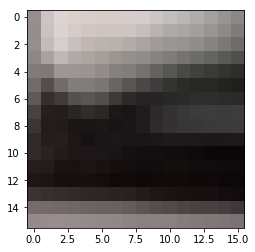

In [21]:
# Predominant color assessment
def dominantWhite(img): 
    return (img>90).sum() > (img2<=90).sum()

img2= cv2.imread('training/vehicles/JWD_vcells/700.PNG')
print('Contains majority white:',dominantWhite(img2))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()


In [49]:
image= cv2.imread('analysis/vlcsnap-00020.png')
v1= image[401:401+158, 924:924+269]
mask= cv2.inRange(v1, np.array([60,60,60]), np.array([255,255,255]) )
output= cv2.bitwise_and(v1, v1, mask= mask)
cv2.imshow("image", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [29]:
cv2.destroyAllWindows()

In [48]:
image= cv2.imread('analysis/vlcsnap-00019.png')
v1= image[389:389+134, 1014:1014+266]
mask= cv2.inRange(v1, np.array([140,140,140]), np.array([255,255,255]) )
output= cv2.bitwise_and(v1, v1, mask= mask)
cv2.imshow("image", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


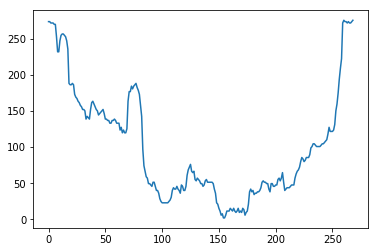

In [50]:
plt.plot(np.sum(mask/134, axis=0))
plt.show()

In [47]:
np.argmax(np.sum(mask/134, axis=0))

121

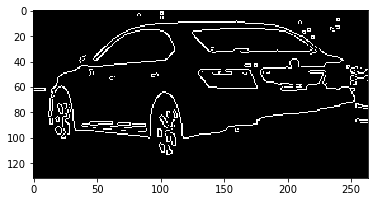

In [52]:
image= cv2.imread('analysis/WhiteTheshold-140.png')
edges= cv2.Canny(image,127,255)
plt.imshow(edges,cmap = 'gray')
plt.show()

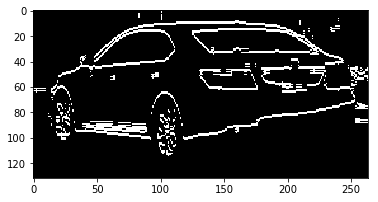

In [68]:
def sobelY(img, threshL=20, threshU=100):
    sobely= cv2.Sobel(img, cv2.CV_16S, 0, 1) # run the derivative in y
    abs_sobely= np.absolute(sobely) # absolute y derivative to accentuate horizontal lines 
    scaled_sobel= np.uint8(255*abs_sobely/np.max(abs_sobely))
    binary= np.zeros_like(img)
    binary[(scaled_sobel >threshL) & (scaled_sobel <= threshU)]= 255 # threshold y gradient
    return binary
image= cv2.imread('analysis/WhiteTheshold-140.png')
edges= sobelY(image,127,255)
plt.imshow(edges,cmap = 'gray')
plt.show()

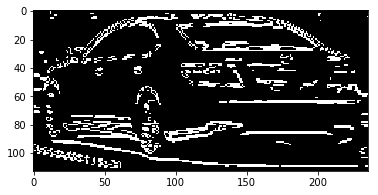

In [81]:
image= cv2.imread('analysis/Vehicle1.PNG')
edges= sobelY(cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,1],200,255)
plt.imshow(edges,cmap = 'gray')
plt.show()

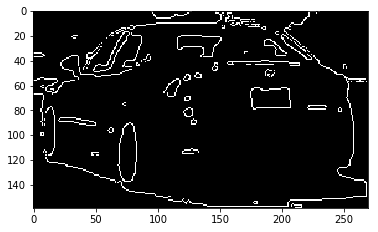

In [53]:
image= cv2.imread('analysis/BlackTheshold-60.png')
edges= cv2.Canny(image,127,255)
plt.imshow(edges,cmap = 'gray')
plt.show()


In [62]:
# Find centroid
lst= [ [0,0,0,0,0,0,0,0,0,0,1,1,1,1,0],
       [0,0,0,0,0,0,0,0,0,1,1,0,1,1,1],
       [0,0,0,0,0,0,0,0,1,0,1,1,0,1,1],
       [0,0,0,0,0,0,0,0,1,0,0,1,0,0,0] ]
n= 0
Xc= 0
Yc= 0
for y in range(0,len(lst)):
    for x in range(0,len(lst[0])):
        if lst[y][x]==1:
            Xc+= x
            Yc+= y
            n+= 1
Yc/= n
Xc/= n
print(Xc,Yc)

11.1875 1.3125


In [2]:
# Find centroid
lst= [ [0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],
       [0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],
       [0,0,0,0,0,0,1,0,1,1,1,1,0,0,0],
       [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0] ]
count= 0
Xc= 0
Yc= 0
for y in range(0,len(lst)):
    for x in range(0,len(lst[0])):
        if lst[y][x]==1:
            Xc+= x
            Yc+= y
            count+= 1
Yc/= count
Xc/= count
print(Xc,Yc)

8.428571428571429 1.2142857142857142


In [8]:
m= cv2.moments(np.array(lst),True)
print(m['m10']/m['m00'], m['m01']/m['m00'])

8.428571428571429 1.2142857142857142


In [13]:
lst= [ [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
       [0,0,0,0,0,0,0,1,1,1,0,0,0,0,0],
       [0,0,0,0,0,0,1,1,1,1,1,0,0,0,0],
       [0,0,0,0,0,1,1,1,1,1,1,1,0,0,0] ]
m= cv2.moments(np.array(lst),True)
print(m['m10']/m['m00'], m['m01']/m['m00'])

8.0 2.125


In [88]:
def locateCentroid(twoDimArray):
    m= cv2.moments(np.array(twoDimArray),True)
    return m['m10']/m['m00'], m['m01']/m['m00']
lst= [ [0,0,0,0,0,1,1,1,1,0,1,1,0,0,1],
       [0,0,0,0,0,1,0,1,1,1,1,1,0,0,1],
       [0,0,0,0,0,1,1,1,0,1,1,1,0,0,0],
       [0,0,0,0,0,1,1,1,1,1,1,1,0,0,0] ]
print(locateCentroid(lst))

(8.481481481481481, 1.4814814814814814)


In [ ]:
previousCenter

In [110]:
# Attempt to remove noise (the '1' in the upper-right corner)
lst2= cv2.fastNlMeansDenoising(np.array(lst,dtype=np.uint8)*255, None,90,2,5)
print( lst2 )
lst3= np.array(lst2 > 200,dtype=np.uint8)
print( lst3 )
 

[[  0   0   0   1   8 233 217 228 214 118 230 238  18   3 196]
 [  0   0   0   1   9 238  81 231 233 244 233 238  18   6 140]
 [  0   0   0   1  10 235 215 232 119 234 211 238  17   7  36]
 [  0   0   0   1   9 224 170 228 237 245 224 239  17  13  12]]
[[0 0 0 0 0 1 1 1 1 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 0 1 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 1 1 1 1 0 0 0]]


In [111]:
print(locateCentroid(lst3))

(8.125, 1.5)


In [130]:
tst1= np.zeros_like(lst)
cv2.ellipse(tst1, ((8.5,1.5), (7,4),0), 1,-1)
print(tst1)

[[0 0 0 0 0 0 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 0 0]]


In [135]:
lst= [ [0,0,0,0,0,0,1,1,1,0,1,0,0,0,1],
       [0,0,0,0,0,1,0,1,1,1,1,1,0,0,1],
       [0,0,0,0,0,1,1,1,0,1,1,1,0,0,0],
       [0,0,0,0,0,1,1,1,1,1,1,1,0,0,0] ]

lst4= cv2.bitwise_and(tst1, np.array(lst))
print( lst4 )

[[0 0 0 0 0 0 1 1 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 0 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 0 0 0]]


In [136]:
print(locateCentroid(lst4))

(8.043478260869565, 1.6956521739130435)


In [21]:
def locateCentroid(twoDimArray, prevCenterTuple):
    mask= np.zeros_like(lst)
    cv2.ellipse(mask, (prevCenterTuple, (7,4),0), 1,-1)
    masked= cv2.bitwise_and(mask, np.array(twoDimArray))
    m= cv2.moments(np.array(masked),True)
    return m['m10']/m['m00'], m['m01']/m['m00']
lst= [ [0,0,0,0,0,1,1,1,1,0,1,1,0,0,1],
       [0,0,0,0,0,1,0,1,1,1,1,1,0,0,1],
       [0,0,0,0,0,1,1,1,0,1,1,1,0,0,0],
       [0,0,0,0,0,1,1,1,1,1,1,1,0,0,0] ]
print( locateCentroid(lst, (8.5,1.5)) )

(8.166666666666666, 1.625)


In [145]:
# Python implementation of HOG based on OpenCV
def histoGrad(img, binCount=12, cellSize=4, fname='fault'):
    gx= cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy= cv2.Sobel(img, cv2.CV_32F, 0, 1)
    magnitude,angle= cv2.cartToPolar(gx,gy)
    bins= np.int32(binCount*angle*(1-1e-7)/(2*np.pi))
    print(angle)
    binCells, magCells= [], []
    cx= cy= cellSize
    for i in range(0,int(img.shape[0]/cy)):
        for j in range(0,int(img.shape[1]/cx)):
            binCells.append(bins[i*cy:i*cy+cy, j*cx:j*cx+cx])
            magCells.append(magnitude[i*cy:i*cy+cy, j*cx:j*cx+cx])
    #print(len(binCells), len(magCells))
    #print(list(zip(binCells, magCells)))
    hists= [np.bincount(i.ravel(), j.ravel(), binCount) for i,j in zip(binCells, magCells)]
    #print(hists)
    hist= np.hstack(hists)
    if len(hist)==193:
        hist= hist[0:192]
        print(fname)
    hist/= hist.sum()+1e-8 # apply Hellinger kernel (L1-normalize and sqrt)
    hist= np.sqrt(hist)
    return hist

img2= cv2.imread('training/vehicles/JWD_vcells/700.PNG')
#print( histoGrad(img2[:,:,0])[:10] )
myhist= histoGrad(img2[:,:,0])

#[ 0.09165663  0.          0.          0.          0.          0.       0.03250726  0.07824319  0.07127868  0.12797922]
#[ 0.09165664  0.          0.          0.          0.          0.       0.03250726  0.0782432   0.07127869  0.12797923]

[[ 0.          0.          0.          3.14159274  3.14159274  3.14159274
   0.          3.14159274  3.14159274  3.14159274  3.14159274  3.14159274
   3.14159274  3.14159274  3.14159274  0.        ]
 [ 4.71238899  6.18719912  5.44392872  3.97764516  4.37002087  4.60391951
   4.65160561  4.54606247  4.3905735   4.32352448  4.40216064  4.38202333
   4.18386459  4.05508327  3.99474263  4.71238899]
 [ 4.71238899  5.89623213  4.9416399   4.15816498  4.39496088  4.50773954
   4.55149508  4.5316906   4.43789816  4.41205215  4.49315739  4.48998308
   4.39644098  4.3301158   4.28186178  4.71238899]
 [ 4.71238899  5.43676472  4.93723869  4.36754322  4.42903376  4.35820055
   4.43404484  4.49093485  4.39929771  4.41892958  4.49052238  4.50454092
   4.49613857  4.47375584  4.45219994  4.71238899]
 [ 4.71238899  5.05407667  5.09052467  4.65981579  4.49246025  4.29191589
   4.33813953  4.4277091   4.3746233   4.39486694  4.44318199  4.47800112
   4.5250206   4.50698566  4.46738338  4.71238899]
 [ 4.

In [15]:
sum(histoGrad(img2[:,:,0]))

0.999999999997


5.9515730336235935

In [18]:
sum(histoGrad(img2[:,:,0]))

5.9515724384742112

In [156]:
hist= np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
#hist /= hist.sum() + 1e-7
print (hist/(hist.sum() + 1e-7))
hist= np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
hist /= (hist.sum() + 1e-7) 
print (hist)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [45]:
print( (i,j) for i,j in zip(hist))

<generator object <genexpr> at 0x000001994148CBA0>


In [142]:
vimages = glob.glob('training/vehicles/JWD_vcells/*.png')
for image in vimages:
    img2= mpimg.imread(image)
    fimage= cv2.cvtColor(img2, cv2.COLOR_RGB2YCrCb)
    for channel in range(fimage.shape[2]):
        myhist= histoGrad(fimage[:,:,channel], fname=image)

In [143]:
img2= mpimg.imread('training/vehicles/JWD_vcells/61-1014-532.PNG')
fimage= cv2.cvtColor(img2, cv2.COLOR_RGB2YCrCb)
print(fimage.shape)

(16, 16, 3)


In [146]:
print(fimage[0,0])
for channel in range(fimage.shape[2]):
    myhist= histoGrad(fimage[:,:,channel])

[ 0.0728      0.50401515  0.52087021]
[[ 0.          3.14159274  3.14159274  3.14159274  3.14159274  3.14159274
   3.14159274  3.14159274  3.14159274  0.          0.          3.14159274
   0.          0.          0.          0.        ]
 [ 1.57079637  2.1042695   1.94992685  1.68124735  1.71910226  1.82815325
   1.74546528  1.88378215  1.89191985  0.78643435  1.11066616  1.91922379
   1.12646139  0.60441834  0.57090032  1.57079637]
 [ 4.71238899  0.68446016  1.38967907  1.67150486  1.77808666  1.97576177
   2.00748181  2.0276618   1.91704881  1.22373843  1.02419317  1.48820281
   1.31441915  0.63171071  6.26012754  4.71238899]
 [ 4.71238899  5.34571218  5.37373829  5.68765926  1.09125829  1.48875332
   1.64409125  1.62946701  1.61827826  1.51362181  1.40500379  1.48031664
   1.6212647   1.75829995  2.98289084  4.71238899]
 [ 4.71238899  5.12962437  4.99639034  5.0162406   5.57970333  0.11236435
   1.18258107  1.42924666  1.55103827  1.5924226   1.59479713  1.86734784
   3.09488797  3.6

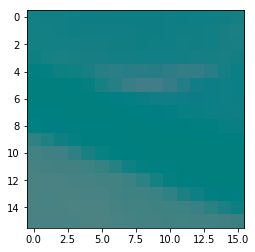

In [100]:
plt.imshow(fimage)
plt.show()

In [119]:
x=[np.array([ 0.        ,  0.05740977,  0.10981189,  0.26433566,  0.02732746,
        0.        ,  0.07629805,  0.        ,  0.        ,  0.25484702,
        0.40318589,  0.        ]), 
   np.array([ 0.        ,  0.        ,  0.4209156 ,  1.34009632,  0.        ,
        0.        ,  0.04164705,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([ 0.03746666,  0.09320346,  1.48847115,  0.51790471,  0.        ,
        0.        ,  0.02386666,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([ 0.23512159,  0.40555992,  0.14375959,  0.86044762,  0.        ,
        0.10582807,  0.        ,  0.        ,  0.        ,  0.17856467,
        0.        ,  0.08876871]), 
   np.array([ 0.00442134,  0.00489744,  0.        ,  0.07923554,  0.        ,
        0.00841992,  0.        ,  0.        ,  0.        ,  2.09209207,
        0.03578462,  0.        ]), 
   np.array([  2.37060040e-01,   0.00000000e+00,   8.91748637e-01,
         0.00000000e+00,   1.28676475e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.83230358e+00,   1.12357363e+00,   6.97881635e-03]), 
   np.array([ 0.        ,  0.        ,  0.68445921,  1.41112117,  0.        ,
        0.        ,  0.        ,  0.        ,  2.6818729 ,  3.24909534,
        0.        ,  0.        ]), 
   np.array([ 0.        ,  0.00583707,  0.        ,  0.03192943,  0.        ,
        0.1604849 ,  0.253647  ,  0.50664485,  1.28004704,  0.76066794,
        0.        ,  0.        ]), 
   np.array([ 0.        ,  0.        ,  0.        ,  8.91285907,  0.120569  ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,                   # <------------- problem 13 elements
         7.04978541e+00,   1.00795419e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.20356176e-02,   0.00000000e+00,
         2.34509818e-03]), 
   np.array([ 0.        ,  0.        ,  0.        ,  1.09371275,  0.34154844,
        0.        ,  0.00534421,  0.00453217,  0.        ,  0.2677984 ,
        0.        ,  0.        ]), 
   np.array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.13772310e-02,   6.32236712e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.10250153e+00,   4.47058864e-03,   4.22893511e-03]), 
   np.array([ 0.10107597,  0.        ,  0.05127015,  0.40661669,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.01568627,
        0.        ,  0.01182166]), 
   np.array([ 0.03316075,  0.        ,  0.05051671,  1.99566305,  0.86572638,
        0.        ,  0.29019606,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([ 0.        ,  0.        ,  0.        ,  7.116294  ,  0.2499977 ,
        0.        ,  0.14447051,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ]), 
   np.array([ 0.        ,  0.        ,  0.        ,  6.46936287,  0.02923101,
        0.        ,  0.68200797,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])]


In [124]:
for i in x: print(i.shape)

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(13,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)


In [ ]:
[(array([[ 0,  6,  6,  6],
       [ 3,  4,  3,  3],
       [ 9,  1,  2,  3],
       [ 9, 10, 10, 10]]), array([[ 0.        ,  0.02174118,  0.03827452,  0.01628235],
       [ 0.01568627,  0.02732746,  0.05361361,  0.07655288],
       [ 0.01423526,  0.05740977,  0.10981189,  0.1184829 ],
       [ 0.24061176,  0.24008824,  0.13351713,  0.02958052]], dtype=float32)), 
 
 (array([[6, 6, 6, 6],
       [3, 3, 3, 3],
       [3, 3, 3, 3],
       [2, 2, 3, 3]]), array([[ 0.00938038,  0.01568627,  0.00784314,  0.00873726],
       [ 0.08208155,  0.0770466 ,  0.06769677,  0.05676446],
       [ 0.10253605,  0.08959732,  0.0649135 ,  0.05473847],
       [ 0.13724345,  0.28367215,  0.3663919 ,  0.37832969]], dtype=float32)), 
 
 (array([[6, 0, 0, 6],
       [3, 1, 2, 3],
       [3, 2, 1, 2],
       [3, 2, 2, 2]]), array([[ 0.00460392,  0.02953725,  0.00792941,  0.01926274],
       [ 0.03944292,  0.03752382,  0.03451458,  0.04494255],
       [ 0.05584636,  0.05062494,  0.05567963,  0.07133739],
       [ 0.37767288,  0.38883558,  0.44360083,  0.49955782]], dtype=float32)), 
 
 (array([[ 0,  0,  0,  0],
       [ 2,  1,  1,  3],
       [ 2,  1, 11,  9],
       [ 3,  3,  5,  9]]), array([[ 0.02174118,  0.07689411,  0.13648629,  0.        ],
       [ 0.0516234 ,  0.11729055,  0.16688228,  0.09411764],
       [ 0.09213619,  0.12138709,  0.08876871,  0.05763131],
       [ 0.47215828,  0.29417169,  0.10582807,  0.12093335]], dtype=float32)), 
 
 (array([[ 9,  9,  9,  9],
       [ 9,  9,  9,  9],
       [ 3,  1,  0, 10],
       [ 3,  3,  3,  5]]), array([[ 0.27607062,  0.35264665,  0.39657491,  0.37088957],
       [ 0.05932549,  0.11735339,  0.20672254,  0.31250888],
       [ 0.00357647,  0.00489744,  0.00442134,  0.03578462],
       [ 0.03758431,  0.027342  ,  0.01073275,  0.00841992]], dtype=float32)), 
 
 (array([[10,  0,  2,  2],
       [10,  9,  9,  9],
       [10,  9,  9,  9],
       [ 4, 11, 10, 10]]), array([[ 0.33283666,  0.23706004,  0.33453956,  0.55720907],
       [ 0.50829172,  0.65860367,  0.68256879,  0.61124712],
       [ 0.17243633,  0.38790631,  0.63679415,  0.85518354],
       [ 0.00128676,  0.00697882,  0.03109698,  0.07891195]], dtype=float32)), 
 
 (array([[2, 3, 3, 3],
       [9, 8, 8, 8],
       [9, 9, 8, 8],
       [9, 9, 9, 9]]), array([[ 0.68445921,  0.66830552,  0.49715114,  0.24566452],
       [ 0.48195171,  0.40111613,  0.48039362,  0.59560531],
       [ 0.96867365,  0.92936027,  0.74235708,  0.46240076],
       [ 0.1577282 ,  0.23756211,  0.25679493,  0.21702448]], dtype=float32)), 
 
 (array([[5, 6, 7, 9],
       [8, 8, 7, 9],
       [8, 8, 1, 3],
       [9, 9, 9, 9]]), array([[ 0.1604849 ,  0.253647  ,  0.28701279,  0.15370986],
       [ 0.58296067,  0.42245543,  0.21963206,  0.06453332],
       [ 0.21087   ,  0.06376095,  0.00583707,  0.03192943],
       [ 0.17498916,  0.15524548,  0.12481757,  0.08737254]], dtype=float32)), 
 
 (array([[3, 3, 3, 4],
       [3, 3, 3, 3],
       [3, 3, 3, 3],
       [3, 3, 3, 3]]), array([[ 0.60536474,  0.50397444,  0.28190112,  0.120569  ],
       [ 0.97370195,  1.00792253,  0.94982421,  0.75806338],
       [ 0.47865105,  0.60567427,  0.82023215,  0.99120826],
       [ 0.12839222,  0.14606726,  0.22485779,  0.4370237 ]], dtype=float32)), 
 
 (array([[ 4,  3, 12, 10],        # <-----------------------------problem: contains a '12', perhaps should be a '0'
       [ 3,  3,  4,  4],
       [ 3,  3,  3,  3],
       [ 3,  3,  3,  3]]), array([[ 0.02867608,  0.00757599,  0.0023451 ,  0.01203562],
       [ 0.45559615,  0.19863945,  0.06144724,  0.0106721 ],
       [ 0.99970371,  0.84381515,  0.58655256,  0.31106469],
       [ 0.71954715,  0.93420213,  1.03178489,  0.96130353]], dtype=float32)), 
 
 (array([[9, 9, 9, 9],
       [7, 6, 9, 9],
       [4, 4, 3, 4],
       [3, 3, 4, 4]]), array([[ 0.01732321,  0.03125613,  0.07196216,  0.12406516],
       [ 0.00453217,  0.00534421,  0.00632237,  0.01686938],
       [ 0.1123475 ,  0.03213956,  0.01320437,  0.00587951],
       [ 0.69865966,  0.38184872,  0.15075047,  0.0404314 ]], dtype=float32)), 
 
 (array([[ 9,  9,  9,  9],
       [ 9,  9,  9,  9],
       [ 4, 11, 10,  9],
       [ 3,  3,  9,  9]]), array([[ 0.15952474,  0.18842112,  0.21819153,  0.21976472],
       [ 0.03034863,  0.05676152,  0.09881474,  0.1197255 ],
       [ 0.00063224,  0.00422894,  0.00447059,  0.00536471],
       [ 0.00909767,  0.00227956,  0.0023451 ,  0.00323922]], dtype=float32)),
 
 (array([[ 3,  3,  3,  3],
       [ 3,  3,  3,  2],
       [ 9,  9, 11,  0],
       [ 0,  0,  0,  0]]), array([[ 0.0604862 ,  0.07706217,  0.10225552,  0.12813143],
       [ 0.00694895,  0.00770867,  0.02402374,  0.05127015],
       [ 0.00784314,  0.00784314,  0.01182166,  0.03687986],
       [ 0.        ,  0.        ,  0.01624316,  0.04795295]], dtype=float32)), 
 
 (array([[3, 3, 3, 3],
       [3, 4, 4, 4],
       [2, 4, 4, 4],
       [0, 6, 6, 6]]), array([[ 0.20926023,  0.34821457,  0.54736716,  0.80205852],
       [ 0.08876258,  0.13516083,  0.15145583,  0.20371996],
       [ 0.05051671,  0.10531563,  0.1573928 ,  0.11268132],
       [ 0.03316075,  0.07058823,  0.12549019,  0.09411764]], dtype=float32)), 
 
 (array([[3, 3, 3, 3],
       [3, 3, 3, 3],
       [4, 4, 3, 3],
       [6, 6, 6, 6]]), array([[ 0.96679169,  0.9414643 ,  0.76208103,  0.49247956],
       [ 0.42901075,  0.71234769,  0.91504472,  0.97472161],
       [ 0.08866442,  0.16133328,  0.33183768,  0.59051496],
       [ 0.03832155,  0.03887841,  0.03201565,  0.0352549 ]], dtype=float32)), 
 
 (array([[3, 3, 4, 3],
       [3, 3, 3, 3],
       [3, 3, 3, 3],
       [6, 6, 6, 0]]), array([[ 0.24282601,  0.09512889,  0.02923101,  0.01141961],
       [ 0.88638353,  0.69486117,  0.45160782,  0.30527845],
       [ 0.84017599,  0.98397762,  1.00596261,  0.95174116],
       [ 0.13576481,  0.24914515,  0.29709801,  0.        ]], dtype=float32))]

In [137]:
print(np.int32(12*6.28318548/(2*np.pi)))

12


In [149]:
12*2*np.pi*(1-1e-7)/(2*np.pi)

11.9999988

In [153]:
np.int32(12*2*np.pi*(1-1e-7)/(2*np.pi))

11

In [73]:
def histoGrad(img, binCount=12, cellSize=4):
    gx,gy= cv2.Sobel(img,cv2.CV_32F,1,0), cv2.Sobel(img,cv2.CV_32F,0,1) # gradients in x and y direction
    print('Sobel derivative in x')
    print(gx)
    print('Sobel derivative in y')
    print(gy)
    magnitude,angle= cv2.cartToPolar(gx,gy)
    print('Angles')
    print(angle)
    print('Magnitudes')
    print(magnitude)
    bins= np.int32(binCount*angle*(1-1e-7)/(2*np.pi)) #scale back angle to avoid overbinning
    print('Bins')
    print(bins)
    binCells,magCells= [],[]
    cx= cy= cellSize
    for i in range(0,int(img.shape[0]/cy)): # sort into bins
        for j in range(0,int(img.shape[1]/cx)):
            binCells.append(bins[i*cy:i*cy+cy, j*cx:j*cx+cx])
            magCells.append(magnitude[i*cy:i*cy+cy, j*cx:j*cx+cx])
    print('binCells')
    print(binCells)
    print('magCells')
    print(magCells)
    print('bincount')
    print([np.bincount(i.ravel(), j.ravel(), binCount) for i,j in zip(binCells, magCells)])
    hist= np.hstack([np.bincount(i.ravel(), j.ravel(), binCount) for i,j in zip(binCells, magCells)])
    print('Unnormal hist')
    print(hist)
    return np.sqrt(hist/(hist.sum()+1e-8)) # apply Hellinger kernel (L1-normalize and sqrt)

image= np.array([
        [1,0,0,0,0,0,0,0],
        [0,1,0,0,0,0,0,0],
        [0,0,1,0,0,0,0,0],
        [0,0,0,1,0,0,0,0],
        [0,0,0,0,1,0,0,0],
        [0,0,0,0,0,1,0,0],
        [0,0,0,0,0,0,1,0],
        [0,0,0,0,0,0,0,1]
       ],dtype=np.uint8)
h= histoGrad(image)
print('Normalized hist')
print(h)

Sobel derivative in x
[[ 0. -2. -2.  0.  0.  0.  0.  0.]
 [ 0.  0. -2. -1.  0.  0.  0.  0.]
 [ 0.  2.  0. -2. -1.  0.  0.  0.]
 [ 0.  1.  2.  0. -2. -1.  0.  0.]
 [ 0.  0.  1.  2.  0. -2. -1.  0.]
 [ 0.  0.  0.  1.  2.  0. -2.  0.]
 [ 0.  0.  0.  0.  1.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  2.  0.]]
Sobel derivative in y
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-2.  0.  2.  1.  0.  0.  0.  0.]
 [-2. -2.  0.  2.  1.  0.  0.  0.]
 [ 0. -1. -2.  0.  2.  1.  0.  0.]
 [ 0.  0. -1. -2.  0.  2.  1.  0.]
 [ 0.  0.  0. -1. -2.  0.  2.  2.]
 [ 0.  0.  0.  0. -1. -2.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
Angles
[[ 0.          3.14159274  3.14159274  0.          0.          0.          0.
   0.        ]
 [ 4.71238899  0.          2.35636115  2.35636115  0.          0.          0.
   0.        ]
 [ 4.71238899  5.49795389  0.          2.35636115  2.35636115  0.          0.
   0.        ]
 [ 0.          5.49795389  5.49795389  0.          2.35636115  2.35636115
   0.          0.        ]
 [ 0.  

In [61]:
from skimage.feature import hog
image= np.array([
        [1,0,0,0,0,0,0,0],
        [0,1,0,0,0,0,0,0],
        [0,0,1,0,0,0,0,0],
        [0,0,0,1,0,0,0,0],
        [0,0,0,0,1,0,0,0],
        [0,0,0,0,0,1,0,0],
        [0,0,0,0,0,0,1,0],
        [0,0,0,0,0,0,0,1]
       ],dtype=np.uint8)
g= hog(image, orientations=12, pixels_per_cell=(4,4), cells_per_block=(1,1), visualise=False, transform_sqrt=False, feature_vector=True)
print(g)
print(np.sqrt(g / (np.sum(np.abs(g)) + 1e-7)))

[ 0.13059909  0.          0.          0.          0.          0.
  0.13059909  0.          0.          0.73877999  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.99936061  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.99936061  0.          0.          0.13059909  0.          0.          0.
  0.          0.          0.13059909  0.          0.          0.73877999
  0.          0.        ]
[ 0.18072235  0.          0.          0.          0.          0.
  0.18072235  0.          0.          0.42983261  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.49992277  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49992277  0.          0.          0.18072235  0.          0.          0.
  0.          0.         

In [71]:
print(np.bincount(np.array([[ 0,  5,  5,  0],
       [ 8,  0,  4,  4],
       [ 8, 7,  0,  4],
       [ 0, 7, 7,  0]]).ravel() ))

[6 0 0 0 3 2 0 3 2]


In [152]:
angles=[]
for i in range(0,361):
    angle=   i % 360
    angles.append(np.int32(12*angle/(360)))
print(angles) #)np.bincount(

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

In [116]:
np.int32((12*360*(np.pi/180.)-1e-16)/(2*np.pi))

12

In [146]:
hist=np.array([1, .7, .4, 0., .1, .05, .08, .02])
m= hist/(hist.sum())
print(m )

[ 0.42553191  0.29787234  0.17021277  0.          0.04255319  0.0212766
  0.03404255  0.00851064]


In [147]:
print(sum(m))

1.0


In [148]:
print(np.sqrt(m))

[ 0.65232807  0.54577682  0.4125685   0.          0.20628425  0.14586499
  0.18450624  0.09225312]


In [149]:
print(sum(np.sqrt(m)) )

2.23958199763
